In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
from defs_cori import *

Define plotting parameters

In [2]:
fig_params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(fig_params)

plot_horizontal = 7.5
plot_vertical = 5.5

re_color = "darkblue"
im_color = "darkred"

re_palette = "Blues"
im_palette = "Reds"

In [3]:
curr_dir = os.getcwd()+'/'
plotdir = curr_dir+"Plots/"

# Langevin evolution Plotting

import the csv

In [4]:
directory = "nrrb_data_d2_w0.1_wt0.2_lambda0.0_m1.0_Nx21_Nt160_dt0.05_nL1000000_eps0.001_mu-0.025"
all_files = os.listdir(directory)
for file in all_files:
    if file.startswith("logfile"):
        filename = directory+"/"+file
    elif file.startswith("inputs"):
        input_filename = directory+"/"+file
#filename = directory+"/logfile_D_2_Nx_21_Nt_160_dt_0.05_nL_1000000_eps_0.001_m_1_wtr_0.1_wz_0_l_0_mu_-0.1.log"
#input_filename = directory+"/inputs_d2_w0.0_wt0.1_lambda0.0_m1.0_Nx21_Nt160_dt0.05_nL1000000_eps0.001_mu-0.1"
p = extract_parameters(curr_dir,input_filename)
data_tL = pd.read_csv(curr_dir+filename)
data_tL = data_tL.rename(columns={"#step": "step"})
data_tL = data_tL.drop(columns=["Unnamed: 9"])

In [5]:
data_tL.head()

,step,Re[phi^{*}phi],Im[phi^{*}phi],Re[<n>],Im[<n>],Re[<Lz>],Im[<Lz>],Re[<S>],Im[<S>]
0,0,0.002114,0.000307,-0.001614,0.001836,0.017089,-0.019313,0.071925,0.022630
1,1,0.004177,0.000434,-0.001680,0.001820,0.018103,-0.018843,0.155436,0.029559
2,2,0.006137,0.000295,-0.001595,0.001824,0.017157,-0.021187,0.238488,0.019679
3,3,0.007989,0.000307,-0.001671,0.001660,0.015875,-0.021663,0.315060,0.015954
4,4,0.010336,0.000150,-0.001521,0.001724,0.015849,-0.024361,0.413280,0.009734


Add a column for the Langevin time, steps scaled by the Langevin stepsize

In [6]:
eps = p["eps"]
tL = data_tL.step*eps
data_tL['tL'] = tL
data_tL.head()

,step,Re[phi^{*}phi],Im[phi^{*}phi],Re[<n>],Im[<n>],Re[<Lz>],Im[<Lz>],Re[<S>],Im[<S>],tL
0,0,0.002114,0.000307,-0.001614,0.001836,0.017089,-0.019313,0.071925,0.022630,0.000
1,1,0.004177,0.000434,-0.001680,0.001820,0.018103,-0.018843,0.155436,0.029559,0.001
2,2,0.006137,0.000295,-0.001595,0.001824,0.017157,-0.021187,0.238488,0.019679,0.002
3,3,0.007989,0.000307,-0.001671,0.001660,0.015875,-0.021663,0.315060,0.015954,0.003
4,4,0.010336,0.000150,-0.001521,0.001724,0.015849,-0.024361,0.413280,0.009734,0.004


Plot real and imaginary density as a function of Langevin time to identify thermalization point. Running averages will be slightly off since they are computed without throwing away the thermalization period yet.

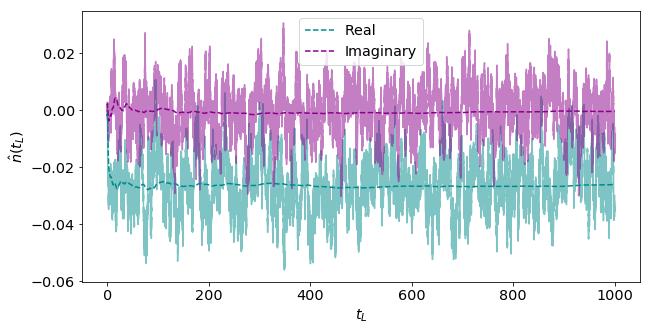

In [7]:
fig, ax = plt.subplots()
nRe = data_tL['Re[<n>]']
nIm = data_tL['Im[<n>]']
tL =  data_tL['tL']  
steps = np.arange(1,len(tL)+1)
ra_Re = np.cumsum(nRe)/steps
ra_Im = np.cumsum(nIm)/steps
ax.plot(tL, nRe, color = "darkcyan",alpha =0.5,label='_nolegend_')
ax.plot(tL, nIm, color = "darkmagenta",alpha =0.5,label='_nolegend_')
ax.plot(tL, ra_Re, ls='dashed', color = "darkcyan", label = "Real")
ax.plot(tL, ra_Im, ls='dashed', color = "darkmagenta", label = "Imaginary")
#determine thermalization point and draw a line on the plot to show it
#therm_step = 200./eps
#ax.axvline(x=200., color = "darkslategray", label = "$n_{steps} = $"+str(therm_step))
ax.legend()
ax.set_xlabel("$t_{L}$")
ax.set_ylabel(r"$\hat{n}(t_{L})$")
plt.savefig(plotdir+"Langevin_evol_example.png",format ='png')
plt.savefig(plotdir+"Langevin_evol_example.pdf",format ='pdf')
plt.show()

## Autocorrelation Error

In [8]:
import acf

Define your bootstrapping function (the '//' forces integer division)

In [9]:
def bootstrap(x, n_blocks, n_iterations):
        n = len(x)
        block_len = n//n_blocks
            
        bs = np.zeros(n_iterations)
        for i in range(n_iterations):
            new_x = np.zeros_like(x)
            for k in range(n_blocks):
                r = np.random.randint(n_blocks)
                bs[i] += x[r*block_len:(r+1)*block_len].mean() / n_blocks
        return bs.std()

Trim your data so you're only looking at thermalized steps

In [10]:
therm_step = 50./eps
print(therm_step)
subset_therm = data_tL[data_tL['step'] > therm_step]

50000.0


Now pick the particular observable you want to bootstrap, set your number of blocks and number of iterations, compute the standard Monte Carlo error on the observable, and then the bootstrapped error. From this you can compute the autocorrelation time and autocorrelation steps.

In [11]:
n_blocks = 50
n_iterations = 1000
x = subset_therm['Re[<n>]']
n = len(x)
xerr_0 = np.std(x)/np.sqrt(n)
xerr_bs = bootstrap(x, n_blocks, n_iterations)
ta_bs = 0.5*((xerr_bs/xerr_0)**2 -1)
sa_bs = ta_bs/eps
print(ta_bs)
print(sa_bs)

2623.26042338
2623260.42338


We're seeing some SERIOUS autocorrelation here...

The density is the most autocorrelated observable with $\tau_{A} \approx 10$. Angular momentum has $\tau_{A} \approx 3$ and field modulus squared has $\tau_{A} \approx 9$. This suggests we need about 1000 steps between saved samples. Now we need to determine how many total samples (after thermalization) we need to get good Monte Carlo statistics. Be sure to incorporate the autocorrelation error: $\Delta_{A} = \sqrt{\frac{Var}{M}(1+2\tau_{A})}$ -- Eventually you will want to calculate this for every value in the dataset.

# Averaged Observables Plotting

In [12]:
filename = "all_averaged_observables.csv"
data_avg = pd.read_csv(curr_dir+filename)
data_avg.head()

,Nt,Nx,beta,dim,dt,eps,lambda,m,mu,nL,...,Im n err,Re Lz,Re Lz err,Re Phisq,Re Phisq err,Re S,Re S err,Re n,Re n err,Ntherm
0,160,41,8.0,2,0.05,1.000,0.0,1.0,-1.000,1000,...,3.647619e+114,5.564796e+114,3.005894e+114,3.332205e+115,9.992863e+114,2.722206e+117,8.163210e+116,-2.955328e+115,8.785008e+114,200
1,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.075,1000000,...,8.948429e-06,-3.008501e-01,7.461705e-05,8.631305e-01,1.040514e-05,3.474682e+01,3.219496e-04,-2.683289e-02,1.000191e-05,200000
2,160,21,8.0,2,0.05,0.100,0.0,1.0,-1.000,10000,...,8.224870e-05,3.407092e-03,8.676344e-04,9.643374e-01,9.580050e-05,3.879442e+01,3.604078e-03,3.243072e-04,8.349531e-05,2000
3,160,21,8.0,2,0.05,0.100,0.0,1.0,-0.400,1000,...,2.967184e-04,-3.268221e-03,3.450776e-03,9.666691e-01,3.584152e-04,3.880046e+01,1.274649e-02,2.625841e-03,3.559248e-04,200
4,160,21,8.0,2,0.05,1.000,0.0,1.0,-0.700,1000,...,4.479313e+125,-3.157778e+124,9.515550e+123,-1.429483e+125,7.029119e+124,-1.160441e+127,5.704237e+126,1.333023e+125,6.114918e+124,200


Add a column for the Langevin time, steps scaled by the Langevin stepsize

In [13]:
data_avg['tL'] = data_avg['eps']*data_avg['nL']
data_avg.head()

,Nt,Nx,beta,dim,dt,eps,lambda,m,mu,nL,...,Re Lz,Re Lz err,Re Phisq,Re Phisq err,Re S,Re S err,Re n,Re n err,Ntherm,tL
0,160,41,8.0,2,0.05,1.000,0.0,1.0,-1.000,1000,...,5.564796e+114,3.005894e+114,3.332205e+115,9.992863e+114,2.722206e+117,8.163210e+116,-2.955328e+115,8.785008e+114,200,1000.0
1,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.075,1000000,...,-3.008501e-01,7.461705e-05,8.631305e-01,1.040514e-05,3.474682e+01,3.219496e-04,-2.683289e-02,1.000191e-05,200000,1000.0
2,160,21,8.0,2,0.05,0.100,0.0,1.0,-1.000,10000,...,3.407092e-03,8.676344e-04,9.643374e-01,9.580050e-05,3.879442e+01,3.604078e-03,3.243072e-04,8.349531e-05,2000,1000.0
3,160,21,8.0,2,0.05,0.100,0.0,1.0,-0.400,1000,...,-3.268221e-03,3.450776e-03,9.666691e-01,3.584152e-04,3.880046e+01,1.274649e-02,2.625841e-03,3.559248e-04,200,100.0
4,160,21,8.0,2,0.05,1.000,0.0,1.0,-0.700,1000,...,-3.157778e+124,9.515550e+123,-1.429483e+125,7.029119e+124,-1.160441e+127,5.704237e+126,1.333023e+125,6.114918e+124,200,1000.0


### Free Gas Plots

Plot density as a function of mu for different $\epsilon$

In [14]:
Nx = 21
Nt = 160
plot_params = {
    #'mu' : -0.01,
    'Nx' : Nx,
    'Nt' : Nt,
    #'eps' : 0.001,
    #'nL' : 300000.0,
    'tL' : 100,
    'wtr' : 0.0, # trap frequecny
    'wz' : 0.0, # rotation frequency
    'lambda' : 0.0, # lambda, contact interaction strength
}
plot_data = data_avg[(data_avg[list(plot_params)] == pd.Series(plot_params)).all(axis=1)]
plot_data.head()

,Nt,Nx,beta,dim,dt,eps,lambda,m,mu,nL,...,Re Lz,Re Lz err,Re Phisq,Re Phisq err,Re S,Re S err,Re n,Re n err,Ntherm,tL
3,160,21,8.0,2,0.05,0.1000,0.0,1.0,-0.4,1000,...,-0.003268,0.003451,0.966669,0.000358,38.800462,0.012746,0.002626,0.000356,200,100.0
13,160,21,8.0,2,0.05,0.0010,0.0,1.0,-0.3,100000,...,-0.010214,0.000304,0.911763,0.000041,36.674285,0.001293,0.000530,0.000038,20000,100.0
15,160,21,8.0,2,0.05,0.0001,0.0,1.0,-0.2,1000000,...,0.009122,0.000108,0.913499,0.000014,36.735266,0.000339,0.003323,0.000014,200000,100.0
26,160,21,8.0,2,0.05,0.0001,0.0,1.0,-0.5,1000000,...,0.008514,0.000096,0.913090,0.000011,36.714671,0.000311,0.002854,0.000011,200000,100.0
28,160,21,8.0,2,0.05,0.0001,0.0,1.0,-0.1,1000000,...,0.009392,0.000113,0.913982,0.000015,36.743913,0.000351,0.003844,0.000016,200000,100.0


Compute analytical solution

In [15]:
import NRRB_analytical_solutions as nrrb_exact
Nt = 160
Nx = 21
mu_list = np.array(plot_data["mu"].unique())
print((mu_list))

[-0.4 -0.3 -0.2 -0.5 -0.1 -0.6 -0.7 -0.8 -1.  -0.9  0. ]


In [16]:
#exact solutions
exact_mu_list = np.arange(-1.,0.,0.05)
exact_phisq = [nrrb_exact.noninteracting_phisq(2,1.0,mu,Nx,Nt,0.05) for mu in exact_mu_list]
exact_dens = [nrrb_exact.noninteracting_density(2,1.0,mu,Nx,Nt,0.05) for mu in exact_mu_list]
d = {'mu': exact_mu_list, 
     'Re Phisq Exact': [i.real for i in exact_phisq],
     'Im Phisq Exact':[i.imag for i in exact_phisq],
    'Re n Exact':[i.real for i in exact_dens],
     'Im n Exact':[i.imag for i in exact_dens],
    }
free_gas_exact = pd.DataFrame(data = d)

Density -- free gas

In [17]:
beta = plot_data['beta'].unique()[0]
x=sorted(mu_list*beta)
x_exact = free_gas_exact["mu"]*beta
exact_n_Re = free_gas_exact['Re n Exact']
exactReerr = np.zeros_like(exact_n_Re)
eps_list = np.array(plot_data["eps"].unique())
eps_list = [0.1,0.01,0.001]
sns.set_palette(re_palette,len(eps_list))

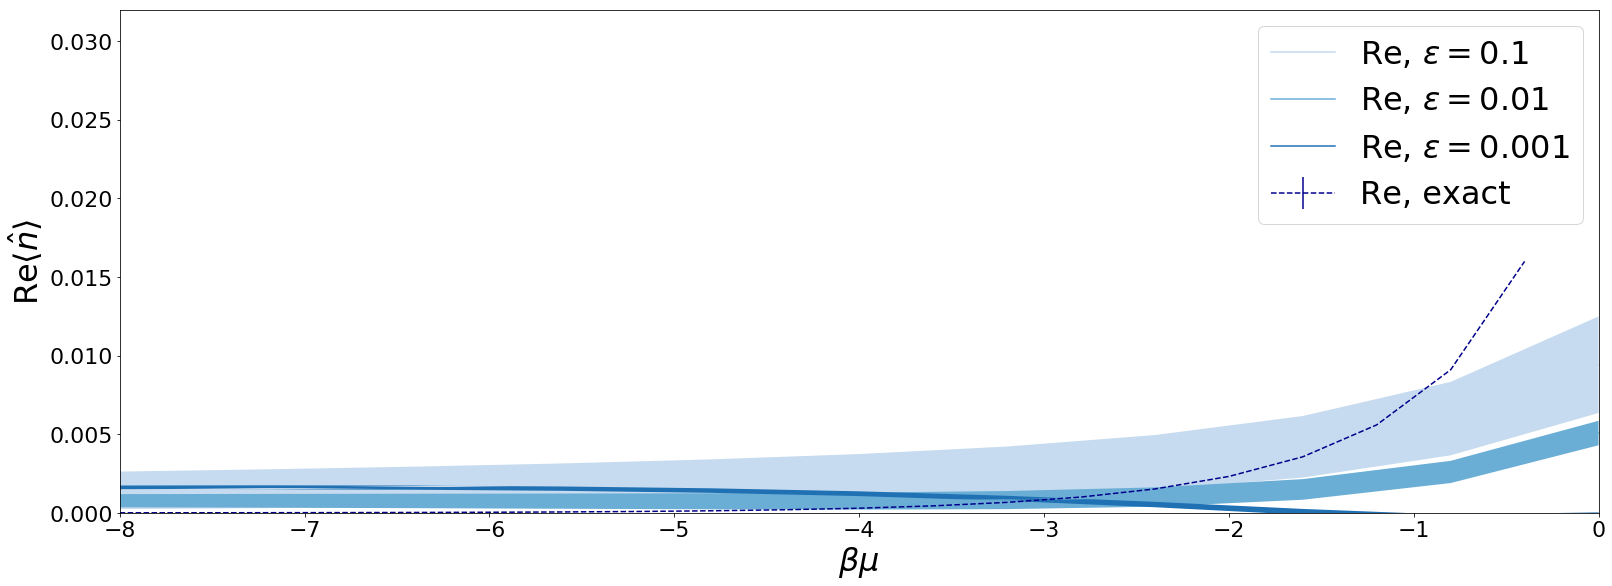

In [18]:
fig, ax = plt.subplots(figsize = (3*plot_horizontal,1.5*plot_vertical))
ax.errorbar(x=x_exact,y=exact_n_Re,yerr = exactReerr,
                   label = "Re, exact", color = re_color,linestyle='--')
for eps in eps_list:
    df = plot_data[plot_data['eps'] == eps]
    df = df.sort_values(by=['mu'])
    x = df["mu"]*beta
    nRe = df['Re n']
    nRe_err = df['Re n err']
    ax.plot(x,nRe,label = "Re, $\epsilon =$"+str(eps))#, color = re_color)
    ax.fill_between(x,nRe-nRe_err,nRe+nRe_err,
                       label="_nolegend_")#, color = re_color, alpha=0.25)
    ax.legend(fontsize=32)
    ax.tick_params(labelsize=22)
    ax.set_xlabel(r"$\beta \mu$", fontsize=32)
    ax.set_ylabel(r"$\mathrm{Re}\langle\hat{n}\rangle$", fontsize=32)
plt.xlim(-8.,0.)
plt.ylim(np.min(exact_n_Re),2.*np.max(exact_n_Re))
plt.tight_layout()
plt.savefig(plotdir+"free_gas_n_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".png",format ='png')
plt.savefig(plotdir+"free_gas_n_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".pdf",format ='pdf')
plt.show()

In [19]:
beta = plot_data['beta'].unique()[0]
x=sorted(mu_list*beta)
x_exact = free_gas_exact["mu"]*beta
exact_n_Im = free_gas_exact['Im n Exact']
exactImerr = np.zeros_like(exact_n_Im)
eps_list = np.array(plot_data["eps"].unique())
eps_list = [0.1,0.01,0.001]
sns.set_palette(im_palette,len(eps_list))

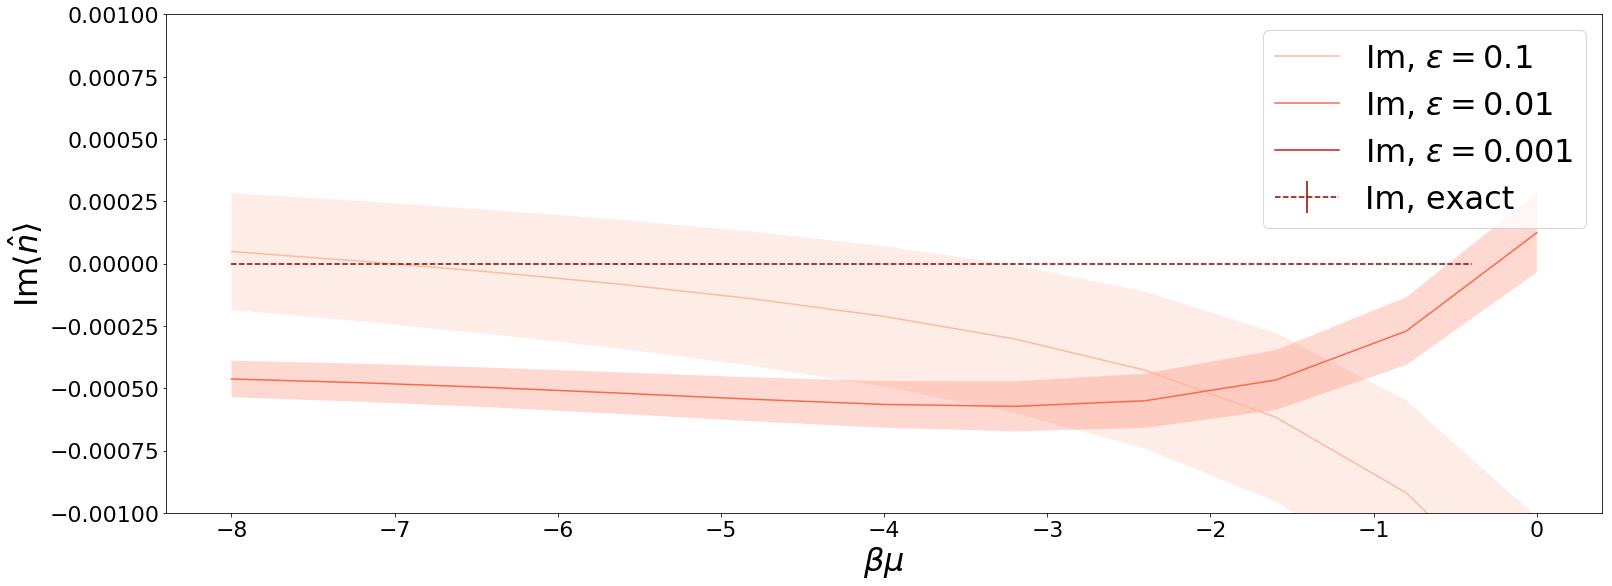

In [20]:
fig, ax = plt.subplots(figsize = (3*plot_horizontal,1.5*plot_vertical))
ax.errorbar(x=x_exact,y=exact_n_Im,yerr = exactImerr,
                   label = "Im, exact", color = im_color,linestyle='--')
for eps in eps_list:
    df = plot_data[plot_data['eps'] == eps]
    df = df.sort_values(by=['mu'])
    x = df["mu"]*beta
    nIm = df['Im n']
    nIm_err = df['Im n err']
    ax.plot(x,nIm,label = "Im, $\epsilon =$"+str(eps))#, color = im_color)
    ax.fill_between(x,nIm-nIm_err,nIm+nIm_err,
                       label="_nolegend_",alpha = 0.25)
    ax.legend(fontsize=32)
    ax.tick_params(labelsize=22)
    ax.set_xlabel(r"$\beta \mu$", fontsize=32)
    ax.set_ylabel(r"$\mathrm{Im}\langle\hat{n}\rangle$", fontsize=32)
#plt.xlim(-8.,0.)
plt.ylim(-0.001,0.001)
#plt.ylim(10.*np.min(exact_n_Im),10.*np.max(exact_n_Im))
plt.tight_layout()
plt.savefig(plotdir+"free_gas_n_Im_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".png",format ='png')
plt.savefig(plotdir+"free_gas_n_Im_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".pdf",format ='pdf')
plt.show()

Field Modulus Squared -- free gas, real

In [21]:
beta = plot_data['beta'].unique()[0]
x=sorted(mu_list*beta)
x_exact = free_gas_exact["mu"]*beta
exact_phisq_Re = free_gas_exact['Re Phisq Exact']
exactReerr = np.zeros_like(exact_phisq_Re)
eps_list = np.array(plot_data["eps"].unique())
eps_list = [0.1,0.01,0.001]
sns.set_palette(re_palette,len(eps_list))

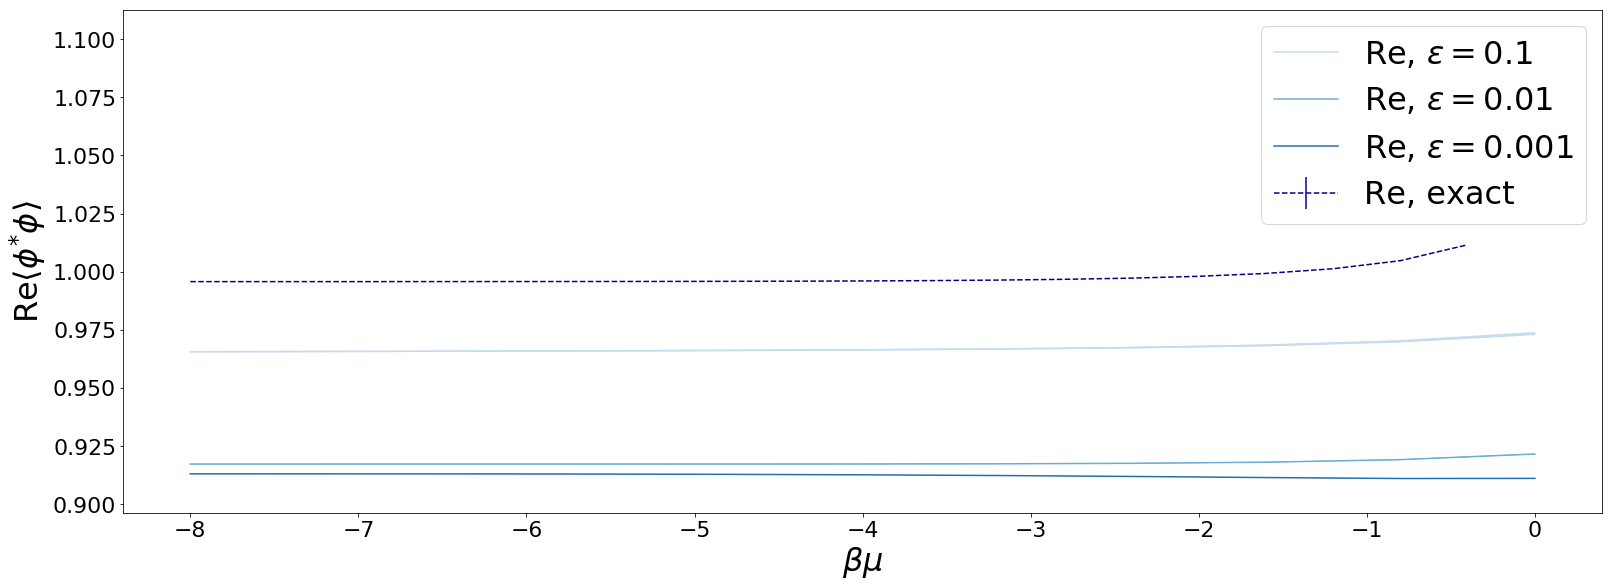

In [22]:
fig, ax = plt.subplots(figsize = (3*plot_horizontal,1.5*plot_vertical))
ax.errorbar(x=x_exact,y=exact_phisq_Re,yerr = exactReerr,
                   label = "Re, exact", color = re_color, linestyle='--')
for eps in eps_list:
    df = plot_data[plot_data['eps'] == eps]
    df = df.sort_values(by=['mu'])
    x = df["mu"]*beta
    phisqRe = df['Re Phisq']
    phisqRe_err = df['Re Phisq err']
    ax.plot(x,phisqRe,label = "Re, $\epsilon =$"+str(eps))#, color = re_color)
    ax.fill_between(x,phisqRe-phisqRe_err,phisqRe+phisqRe_err,
                       label="_nolegend_")#, color = re_color, alpha=0.25)
    ax.legend(fontsize=32)
    ax.tick_params(labelsize=22)
    ax.set_xlabel(r"$\beta \mu$", fontsize=32)
    ax.set_ylabel(r"$\mathrm{Re}\langle\phi^{*}\phi\rangle$", fontsize=32)
plt.ylim(0.9*np.min(exact_phisq_Re),1.1*np.max(exact_phisq_Re))
plt.tight_layout()
plt.savefig(plotdir+"free_gas_phisq_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".png",format ='png')
plt.savefig(plotdir+"free_gas_phisq_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".pdf",format ='pdf')
plt.show()

In [23]:
beta = plot_data['beta'].unique()[0]
x=sorted(mu_list*beta)
x_exact = free_gas_exact["mu"]*beta
exact_phisq_Im = free_gas_exact['Im Phisq Exact']
exactImerr = np.zeros_like(exact_phisq_Im)
eps_list = np.array(plot_data["eps"].unique())
eps_list = [0.1,0.01,0.001]
sns.set_palette(im_palette,len(eps_list))

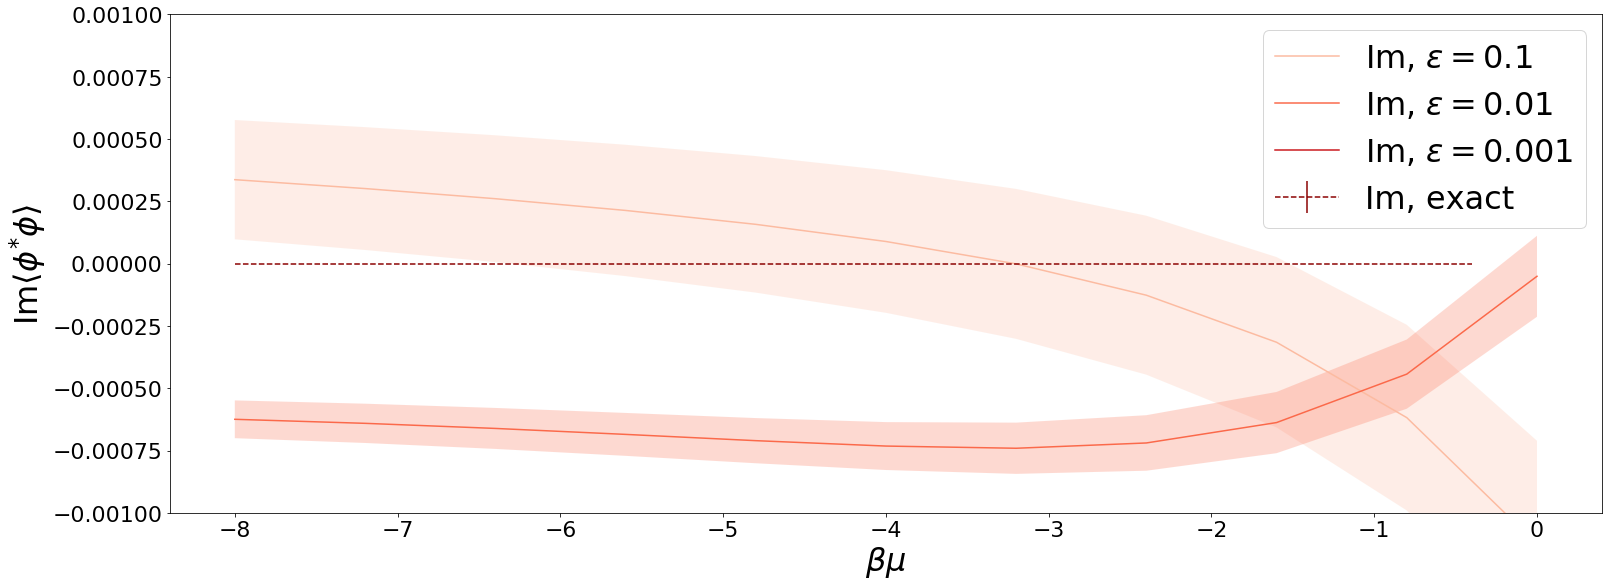

In [24]:
fig, ax = plt.subplots(figsize = (3*plot_horizontal,1.5*plot_vertical))
ax.errorbar(x=x_exact,y=exact_phisq_Im,yerr = exactImerr,
                   label = "Im, exact", color = im_color,linestyle='--')
for eps in eps_list:
    df = plot_data[plot_data['eps'] == eps]
    df = df.sort_values(by=['mu'])
    x = df["mu"]*beta
    phisqIm = df['Im Phisq']
    phisqIm_err = df['Im Phisq err']
    ax.plot(x,phisqIm,label = "Im, $\epsilon =$"+str(eps))#, color = im_color)
    ax.fill_between(x,phisqIm-phisqIm_err,phisqIm+phisqIm_err,
                       label="_nolegend_",alpha = 0.25)
    ax.legend(fontsize=32)
    ax.tick_params(labelsize=22)
    ax.set_xlabel(r"$\beta \mu$", fontsize=32)
    ax.set_ylabel(r"$\mathrm{Im}\langle\phi^{*}\phi\rangle$", fontsize=32)
plt.ylim(0.5*np.min(exact_phisq_Im),1.5*np.max(exact_phisq_Im))
plt.ylim(-0.001,.001)
plt.tight_layout()
plt.savefig(plotdir+"free_gas_phisq_Im_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".png",format ='png')
plt.savefig(plotdir+"free_gas_phisq_Im_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".pdf",format ='pdf')
plt.show()

## Angular Momentum plots

In [25]:
Nx = 21
Nt = 160
plot_params = {
    'mu' : -0.05,
    'Nx' : Nx,
    'Nt' : Nt,
    'eps' : 0.001,
    #'nL' : 300000.0,
    'tL' : 1000,
    #'wtr' : 0.2, # trap frequecny
    #'wz' : 0.0, # rotation frequency
    'lambda' : 0.0, # lambda, contact interaction strength
}
plot_data = data_avg[(data_avg[list(plot_params)] == pd.Series(plot_params)).all(axis=1)]
plot_data.head()

,Nt,Nx,beta,dim,dt,eps,lambda,m,mu,nL,...,Re Lz,Re Lz err,Re Phisq,Re Phisq err,Re S,Re S err,Re n,Re n err,Ntherm,tL
19,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.05,1000000,...,-0.005122,0.000075,0.865217,0.000011,34.840836,0.000326,-0.025997,0.000010,200000,1000.0
49,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.05,1000000,...,-0.367601,0.000097,0.898302,0.000013,36.017941,0.000380,-0.005333,0.000013,200000,1000.0
108,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.05,1000000,...,-0.007898,0.000098,0.900939,0.000013,36.149554,0.000385,-0.004321,0.000013,200000,1000.0
197,160,21,8.0,2,0.05,0.001,0.0,1.0,-0.05,1000000,...,-0.301178,0.000075,0.863366,0.000011,34.744997,0.000324,-0.026573,0.000010,200000,1000.0


In [26]:
wtr_list = plot_data["wtr"].unique()
sns.set_palette(im_palette,len(wtr_list))

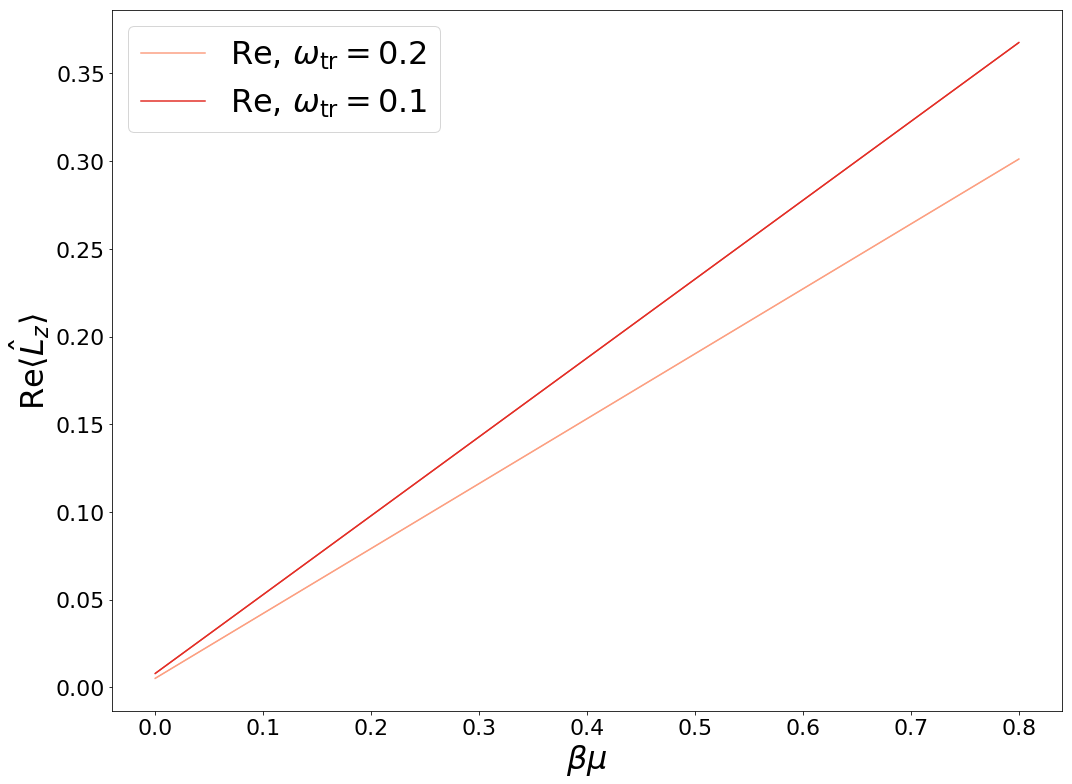

In [27]:
fig, ax = plt.subplots(figsize = (2*plot_horizontal,2*plot_vertical))
for wtr in wtr_list:
    df = plot_data[plot_data['wtr'] == wtr]
    df = df.sort_values(by=['wz'])
    x = df["wz"]*beta
    LzRe = -1.*df['Re Lz']
    LzRe_err = df['Re Lz err']
    ax.plot(x,LzRe,label = "Re, $\omega_{\mathrm{tr}} =$"+str(wtr))#, color = re_color)
    ax.fill_between(x,LzRe-LzRe_err,LzRe+LzRe_err,
                       label="_nolegend_")#, color = re_color, alpha=0.25)
    ax.legend(fontsize=32)
    ax.tick_params(labelsize=22)
    ax.set_xlabel(r"$\beta \mu$", fontsize=32)
    ax.set_ylabel(r"$\mathrm{Re}\langle\hat{L}_{z}\rangle$", fontsize=32)
#plt.xlim(-8.,0.)
#plt.ylim(np.min(exact_n_Re),2.*np.max(exact_n_Re))
plt.tight_layout()
plt.savefig(plotdir+"free_gas_n_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".png",format ='png')
plt.savefig(plotdir+"free_gas_n_Re_Nx_"+str(Nx)+"_Nt_"+str(Nt)+".pdf",format ='pdf')
plt.show()